In [2]:
using LinearAlgebra
import Pkg
Pkg.add("Plots")
using Plots
Pkg.add("LaTeXStrings")
using LaTeXStrings

    Updating registry at `C:\Users\Markus\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\Markus\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\Markus\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Markus\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\Markus\.julia\environments\v1.7\Manifest.toml`


In [3]:
using Fermions

Anderson impurity model with 1 atom and several bath sites (not half-filled)
----------------------------------------------------------------------------------------

$$
H = -\mu \sum_\sigma c^\dagger_{1\sigma} c_{1\sigma} + U n_{1\uparrow} n_{1\downarrow} 
+ \sum_{i>1,\sigma} V_{1i} c^\dagger_{1\sigma} c_{i\sigma} + h.c. - \sum_{i>1,\sigma} \epsilon_{i} c^\dagger_{i\sigma} c_{i\sigma}
$$
where the flavours are $\uparrow1, \uparrow2, \uparrow3, \downarrow1, \downarrow2, \downarrow3 \cdots$

In [4]:
nsites = 4
#t = 1.0
u = 2.0
mu = 1.33168

# 6 bath sites (GF is fast, but P3 takes quite long)
#epsilons = [-3.3222061 , -1.39508342, -0.27908811,  0.36578404,  1.62122836,
 #       3.76701005]
#vksq = [0.70669434, 0.88584406, 0.33253184, 0.33283158, 0.96772167,
  #     0.77189007]

# 5 bath sites
#epsilons = [-2.79245855, -0.8460881 ,  0.00907373,  1.00479852,  3.17202384]
#vksq = [1.06150688, 0.73752328, 0.23223445, 0.79217678, 1.16486242]

# 4 bath sites
#epsilons = [-2.22846159, -0.36627436,  0.45552273,  2.5497922 ]
#vksq = [1.41296559, 0.4824027 , 0.49958433, 1.54991471]
#vks = sqrt.(vksq)

# 3 bath sites
epsilons = [-1.59210263e+00, -1.59477752e-03,  1.82320307e+00]
vksq = [1.64655664, 0.30834254, 1.80770532]
vks = sqrt.(vksq)

3-element Vector{Float64}:
 1.2831822317971833
 0.5552859983828153
 1.3445093231361396

First, we need to create a finite Fock space. Since we have `nsites` sites with two spins each, the number of flavours is `2 * nsites`

In [5]:
space = FockSpace(2 * nsites)

FockSpace{UInt64}(8, 0x00000000000000ff)

To express the Hamiltonian above, we need the annihilation operators
$c_{i\sigma}$. `annihilators` returns an array of these objects. Now,
to add a spin dimension, we simply reshape that array so that the second index corresponds to a spin index.

In [6]:
c = reshape(annihilators(space), (nsites, 2))

4×2 Matrix{Operator{Int8, Tuple{Term{Int8, UInt64}}, FockSpace{UInt64}}}:
 1 c[1]  1 c[5]
 1 c[2]  1 c[6]
 1 c[3]  1 c[7]
 1 c[4]  1 c[8]

The creation operator is simply given by conjugate transpose, e.g., `c[1,1]'`.  A normal ordered product (`Term`) can now be formed by simply multiplying operators:

Creating the Hamiltonian now involves a sum of terms.  For this,
we create a `Operator` instance and simply add terms to it:

In [7]:
H = Operator(space)
H -= mu * (c[1,1]' * c[1,1] + c[1,2]' * c[1,2]) 
H += u * c[1,1]' * c[1,2]' * c[1,2] * c[1,1]
for i in 2:nsites
    for σ in 1:2
        H -= epsilons[i-1] * c[i,σ]' * c[i,σ]
        H += vks[i-1] * (c[1,σ]' * c[i,σ] + c[i,σ]' * c[1,σ])
    end
end
H

Operator{Float64, Vector{Term{Float64, UInt64}}, FockSpace{UInt64}} for 8 flavours (21 terms):
1.3445093231361396 c[5]' c[8]
0.5552859983828153 c[5]' c[7]
1.2831822317971833 c[5]' c[6]
1.3445093231361396 c[1]' c[4]
0.5552859983828153 c[1]' c[3]
1.2831822317971833 c[1]' c[2]
-1.33168 n[1]
1.59210263 n[2]
0.00159477752 n[3]
-1.82320307 n[4]
-1.33168 n[5]
2.0 n[1] n[5]
1.59210263 n[6]
0.00159477752 n[7]
-1.82320307 n[8]
1.2831822317971833 c[2]' c[1]
0.5552859983828153 c[3]' c[1]
1.3445093231361396 c[4]' c[1]
1.2831822317971833 c[6]' c[5]
0.5552859983828153 c[7]' c[5]
1.3445093231361396 c[8]' c[5]

In [8]:
ishermitian(H)

using SparseArrays
sparse(H)

256×256 SparseMatrixCSC{Float64, Int64} with 1023 stored entries:
⢿⢗⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠉⢱⣶⢄⢢⡀⠀⠀⠀⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠠⣑⠛⣤⣌⡢⠀⠀⠀⠈⠆⠀⠀⠀⠀⠀⠀⠀⠀⠙⠆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠢⡹⠵⢇⣀⠀⠀⠀⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠘⣟⣽⠀⠀⠀⠀⠀⠈⢢⡀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠈⠳⡀⠀⠀⠀⠀⠀⢿⢗⡆⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠈⠁⠀⠀⠀⠀⠈⠉⢱⣶⢤⠢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠠⡀⠀⠀⠀⠠⡓⠛⣤⣜⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠂⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠈⠲⠄⠀⠀⠈⠲⠙⠵⢇⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢿⣷⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀
⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢿⣷⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠈⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⢱⢖⣄⠦⡀⠀⠀⠐⠦⡀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠠⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠠⡝⠛⣤⢬⠂⠀⠀⠀⠈⠂⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⠓⠿⢇⣀⡀⠀⠀⠀⠀⢀⡀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠸⢵⣷⠀⠀⠀⠀⠀⠈⢦⡀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠈⠣⡀⠀⠀⠀⠀⠀⣟⣽⡄⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠉⢱⢖⣎⠢⡀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠰⣄⠀⠀⠀⠀⠀⠀⠀⠀⠰⡀⠀⠀⠀⠪⡙⠛⣤⢍⠂⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⠀⠀⠀⠈⠣⠑⠿⢇⣀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢵⣷

**On-the-fly evaluation**

The elements are not stored anywhere, which means the size grows only with the number of terms:

If we want to construct a CSC sparse matrix from the operator, then one 
can use the `sparse()` function.  For small matrices, one can also
use the `Array()` function to get a dense matrix instead.

Using symmetries
----------------

Even with on-the-fly evaluation, the Fock space will grow too quickly,
which bars us from constructing the vectors.  However, we can remedy
that using symmetries.

The Hamiltonian conserves the total number of particles $N$ as well
as the total spin in $z$-direction $S_{z,tot}$.  We construct a
set of quantum numbers for those:

In [9]:
quantum_numbers = NSzSet(space)

NSet{2}(FockSpace{UInt64}(8, 0x00000000000000ff), 4, 4)

In [10]:
conserves(quantum_numbers, H)

true

This partitions the Fock space into a set of blocks

**Block operator**

We can also construct just one block for some values of quantum numbers.
For example, the following gets only the block with a filling close to
half in each spin.

In [11]:
using Fermions.Propagators
Pkg.add("SparseIR")
using SparseIR

   Resolving package versions...
  No Changes to `C:\Users\Markus\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\Markus\.julia\environments\v1.7\Manifest.toml`


In [12]:
beta = 10

10

In [13]:
ham_eb = Fermions.Propagators.HamiltonianEigen(H, quantum_numbers, beta)

HamiltonianEigen{Operator{Float64, Vector{Term{Float64, UInt64}}, FockSpace{UInt64}}, NSet{2}, Tuple{Int64, Int64}, Fermions.NSetBlock{2}, Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}}(1.3445093231361396 c[5]' c[8]
0.5552859983828153 c[5]' c[7]
1.2831822317971833 c[5]' c[6]
1.3445093231361396 c[1]' c[4]
0.5552859983828153 c[1]' c[3]
1.2831822317971833 c[1]' c[2]
-1.33168 n[1]
1.59210263 n[2]
0.00159477752 n[3]
-1.82320307 n[4]
-1.33168 n[5]
2.0 n[1] n[5]
1.59210263 n[6]
0.00159477752 n[7]
-1.82320307 n[8]
1.2831822317971833 c[2]' c[1]
0.5552859983828153 c[3]' c[1]
1.3445093231361396 c[4]' c[1]
1.2831822317971833 c[6]' c[5]
0.5552859983828153 c[7]' c[5]
1.3445093231361396 c[8]' c[5], NSet{2}(FockSpace{UInt64}(8, 0x00000000000000ff), 4, 4), Dict{Tuple{Int64, Int64}, Fermions.NSetBlock{2}}((1, 2) => Fermions.NSetBlock{2}(nflv=8, Ntot=1, Ntot=2), (3, 1) => Fermions.NSetBlock{2}(nflv=8, Ntot=3, Ntot=1), (0, 2) => Fermions.NSetBlock{2}(nflv=8, Ntot=0, Ntot=2), (1, 3) => Fermions

We can use the `full_tau` function of the Propagators module: it expects the operators and a tau grid to use:

The Fourier transform is available using the `full_freq` function:
$$
    \hat G(i\omega_n) = \int_0^\beta \exp(i\omega_n\tau) G(\tau) d\tau
$$
The Matsubara frequencies have to be specified as `FermionicFreq` or
`BosonicFreq` objects, where the argument is the prefactor to $i\pi/\beta$, i.e., odd numbers for fermionic frequencies and even numbers for bosonic
frequencies.

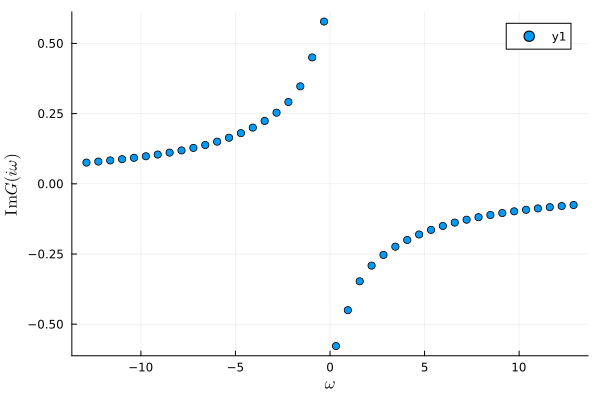

In [14]:
#import Pkg
#Pkg.add("Plots")
using Plots

A = -c[1, 1]
B = c[1, 1]'

wn = FermionicFreq(-41):FermionicFreq(41)
w = SparseIR.value.(wn, beta);

giw = full_freq((A, B), wn, ham_eb, beta)

Plots.scatter(w, imag.(giw), xlabel=L"\omega", ylabel=L"\mathrm{Im} G(i\omega)")

In [15]:
#import Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
using CSV
using DataFrames

data = CSV.read("data.csv", DataFrame, delim=" ",ignorerepeated=true, header=false) 

   Resolving package versions...
  No Changes to `C:\Users\Markus\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\Markus\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Markus\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\Markus\.julia\environments\v1.7\Manifest.toml`


LoadError: ArgumentError: "data.csv" is not a valid file or doesn't exist

In [16]:
giw_origin_im = data[!,7]
#giw_origin_re = data[!,6]
w_origin = data[!,5]
plt=Plots.scatter(w_origin, giw_origin_im, xlabel=L"\omega", ylabel=L"\mathrm{Im} G(i\omega)")
#plt=Plots.scatter(w_origin, giw_origin_re, xlabel=L"\omega", ylabel=L"\mathrm{Re} G(i\omega)")
Plots.scatter!(plt,w, imag.(giw), xlabel=L"\omega", ylabel=L"\mathrm{Im} G(i\omega)")

LoadError: UndefVarError: data not defined

Multi-point Green's function
----------------------------

To compute Greens functions of the form:
$$
    G_{ABC}(\tau') = \langle T A(\tau) B(\tau') C(0) \rangle
$$
from the Lehmann representation, we can use the same function,
but we need to specify three operators and a list of tuples
$(\tau,\tau')$.

In [17]:
# split the area into two simplices

using SimplexQuad

function G_ABC_gl_part_simplex_array(A, B, C, H, β, space, ω1, ω2, τ_arr1, τ_arr2, weights, ham_eb)
    #temp=transpose(weights*ℯ.^(im*ω2*transpose(τ_arr2.*β))*transpose(ones(length(weights))*ℯ.^(im*ω1*transpose(τ_arr1.*β))*G_ABC(A,B,C,τ_arr1.*β,τ_arr2.*β,H,β,space,0.0)))
    #return temp
    
    #w=transpose(ones(length(weights)))
    #weightmatrix = transpose(weights*w)
    #println(weightmatrix)
    
    f_vector = Array{typeof(zero(ComplexF64)), 1}(undef,length(τ_arr1))
    
    for f in 1:length(f_vector) 
        f_vector[f] = 0
    end
    
    #println(size(weights))
    #println(size(τ_arr1))
    #println(size(f_vector))
    
    #tautau = collect(Iterators.product(τ_arr1*β,τ_arr2*β))
    tautau = []
    for f in 1:length(f_vector)
        τ_1= τ_arr1[f]
        τ_2= τ_arr2[f]
        #tautau = collect(Iterators.product( τ_1*β,τ_2*β))
        push!(tautau, (τ_1*β,τ_2*β))
    end
    #print(tautau)
    #Tuple(Float64(x) for x in pointlist)
    
    #f_vector = (ℯ.^(im*ω1*transpose(τ_arr1)*β)) * full_tau((A1,B1,C1), tautau, ham_eb, β) * (ℯ.^(im*transpose(ω2)*τ_arr2*β))
    
    #matrix1 = (ℯ.^(im*ω1*transpose(τ_arr1)*β))
    matrix2 = full_tau((A,B,C), tautau, ham_eb, β) 
    #matrix3 = (ℯ.^(im*transpose(ω2)*τ_arr2*β))
    
    
    for f in 1:length(f_vector) 
        τ_1= τ_arr1[f]
        τ_2= τ_arr2[f]
        #tautau = collect(Iterators.product( τ_1*β,τ_2*β))
        
        #f_vector[f] = ℯ.^(im*ω1*τ_1*β)*G_ABC(A,B,C,[τ_1*β],[τ_2*β],H,β,space,0.05)[1,1]*ℯ.^(im*ω2*τ_2*β)
        #f_vector[f] = ℯ.^(im*ω1*τ_1*β)* full_tau((A1,B1,C1), tautau, ham_eb, β)[1,1] * ℯ.^(im*ω2*τ_2*β)
        f_vector[f] = ℯ.^(im*ω1*τ_1*β)* matrix2[f] * ℯ.^(im*ω2*τ_2*β)
    end
    #println(dot(weights*β*β,f_vector))
    #println("------")
    

    return dot(weights*β*β,f_vector)
    
    #println(size(f_vector))
    #return weights*β*β*f_vector
    
end

function G_ABC_gl_transform_simplex(A, B, C, H, β, space, n_max1, n_max2)
    n1 = collect(-n_max1:1:n_max1)
    ω1 = (2n1.+0)*π/β
    
    n2 = collect(-n_max2:1:n_max2)
    ω2 = (2n2.+0)*π/β
    
    X, W = simplexquad(50, 2)
    #X, W = simplexquad(10, 2)
    Y=1 .-X
    
    
    quantum_numbers = NSzSet(space)
    ham_eb = Fermions.Propagators.HamiltonianEigen(H, quantum_numbers, beta)
    
    #G_fun1 = G_ABC(A,B,C,(1 .-X[:,1])*β,(X[:,2])*β,H,β,space,0.05)
    #G_fun2 = G_ABC(A,B,C,(1 .-Y[:,1])*β,(Y[:,2])*β,H,β,space,0.05)
    
    #println((X))
    
    result = Array{typeof(zero(ComplexF64)), 2}(undef,length(ω1),length(ω2)) 
    for j in 1:length(ω1)
        for k in 1:length(ω2)    

            values1 = G_ABC_gl_part_simplex_array(A, B, C, H, β, space, ω1[j], ω2[k], 1 .-X[:,1],X[:,2],W, ham_eb)
            values2 = G_ABC_gl_part_simplex_array(A, B, C, H, β, space, ω1[j], ω2[k], 1 .-Y[:,1],Y[:,2],W, ham_eb)
            #println(W)
            #println(values1)
            #println(values2)

            #integral = dot(W,values1)+dot(W,values2)
            integral = values1+values2

            #println("Done with ", j, ", ", k)
            #println(size(integral))
            result[j,k] = integral
        end
    end
    #result = integral
    return result
end




G_ABC_gl_transform_simplex (generic function with 1 method)

In [18]:
wn = BosonicFreq(-30):BosonicFreq(30)
ww = collect(Iterators.product(wn, wn))
w = SparseIR.value.(wn, beta);

A1 = c[1, 1]' * c[1, 1]
B1 = c[1, 1]' * c[1, 1]
C1 = c[1, 1]' * c[1, 1]

tau = 0:0.1:beta
tautau = collect(Iterators.product( tau,tau))

@time R1_tau = full_tau((A1,B1,C1), tautau, ham_eb, beta)

""
#plot(tau,tau,real.(R1_tau), st=:surface)

  3.841928 seconds (7.55 M allocations: 358.529 MiB, 5.67% gc time, 96.96% compilation time)


""

In [19]:
@time R1_omega = G_ABC_gl_transform_simplex(A1, B1, C1, H, beta, space, 11, 11)


108.265302 seconds (30.48 M allocations: 2.781 GiB, 0.98% gc time, 7.09% compilation time)


23×23 Matrix{ComplexF64}:
   -8.9525e-5-3.83437e-16im  …      0.131507+7.77156e-16im
 -0.000105639-6.85487e-16im       -0.0013526+2.18575e-16im
 -0.000126419-6.14092e-16im      -0.00109034+4.04191e-16im
 -0.000153752-1.0378e-15im      -0.000941972-8.06646e-16im
 -0.000190484-3.01842e-16im     -0.000852169+2.9924e-16im
 -0.000240983+3.99854e-16im  …  -0.000808941+4.69243e-16im
 -0.000311966+4.44957e-16im     -0.000808941+1.45283e-17im
 -0.000413663-3.90313e-16im     -0.000852169-1.44849e-16im
  -0.00056152-1.10328e-15im     -0.000941972+5.06539e-16im
 -0.000782539-1.32186e-15im      -0.00109034+8.43076e-16im
  -0.00115191+1.18308e-15im  …    -0.0013526-1.2039e-15im
     0.131507-3.9968e-15im          0.131507+3.9968e-15im
   -0.0013526+1.2039e-15im       -0.00115191-1.18308e-15im
  -0.00109034-8.43076e-16im     -0.000782539+1.32186e-15im
 -0.000941972-5.06539e-16im      -0.00056152+1.10328e-15im
 -0.000852169+1.44849e-16im  …  -0.000413663+3.90313e-16im
 -0.000808941-1.45283e-17im     -

3.9968028886505635e-15


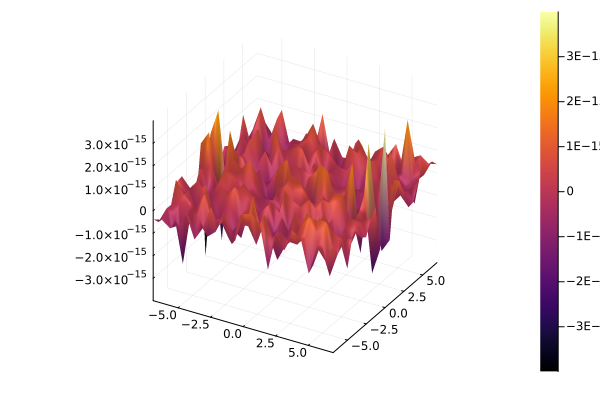

In [20]:
wn = BosonicFreq(-22):BosonicFreq(22)
ww = collect(Iterators.product(wn, wn))
w = SparseIR.value.(wn, beta);
#println(w)
#println(maximum(real.(R1_omega)))
#plot(w,w,real.(R1_omega), st=:surface)
#plot(w,w,real.(R1_omega))

#Pkg.add("PyPlot")
#using PyPlot;
#surf(w, w, real.(R1_omega))

#heatmap(w, w, real.(R1_omega), c = :thermal)


function showMeThe(R_what)
   wn = BosonicFreq(-22):BosonicFreq(22)
    ww = collect(Iterators.product(wn, wn))
    w = SparseIR.value.(wn, beta);
    #println(w)
    println(maximum(imag.(R_what)))
    plot(w,w,imag.(R1_omega), st=:surface)
    #heatmap(w, w, imag.(R_what), c = :thermal) 
end

showMeThe(R1_omega)

In [21]:
A4 = c[1, 1]' * c[1, 1]
B4 = c[1, 1]' * c[1, 1]
C4 = c[1, 2]' * c[1, 2]

R4_tau = full_tau((A4,B4,C4), tautau, ham_eb, beta)

101×101 Matrix{Float64}:
 0.257418  0.221887  0.198584  0.183069  …  0.198584  0.221887  0.257418
 0.221887  0.258715  0.223989  0.200994     0.181991  0.197792  0.221887
 0.198584  0.223989  0.261544  0.227144     0.17119   0.181991  0.198584
 0.183069  0.200994  0.227144  0.264902     0.164047  0.171468  0.183069
 0.172568  0.185521  0.204209  0.230578     0.15924   0.164338  0.172568
 0.165332  0.17493   0.188664  0.207588  …  0.155939  0.159417  0.165332
 0.160252  0.167549  0.177942  0.191924     0.153623  0.155951  0.160252
 0.156615  0.162307  0.17041   0.181061     0.151959  0.153459  0.156615
 0.153957  0.158512  0.165018  0.173386     0.150733  0.151626  0.153957
 0.151973  0.155709  0.161085  0.167862     0.149806  0.150247  0.151973
 0.150463  0.153598  0.158159  0.16381   …  0.149086  0.149186  0.150463
 0.149288  0.151977  0.155941  0.16078      0.148513  0.148351  0.149288
 0.148356  0.150707  0.154227  0.158473     0.148046  0.14768   0.148356
 ⋮                        

In [22]:
@time R4_omega = G_ABC_gl_transform_simplex(A4, B4, C4, H, beta, space, 11, 11)


106.006964 seconds (16.33 M allocations: 2.061 GiB, 0.65% gc time)


23×23 Matrix{ComplexF64}:
  1.42528e-6-2.06435e-16im  …     0.134359-2.22045e-16im
  1.81523e-6-6.85948e-16im      0.00056333-7.63278e-17im
  2.34828e-6-3.09865e-16im     0.000344301+2.37657e-16im
  3.09173e-6-6.73615e-16im     0.000240006-1.09721e-15im
  4.15113e-6-1.95156e-16im     0.000179142+2.77556e-16im
  5.69559e-6+3.39789e-16im  …  0.000140697+4.29344e-16im
  7.99982e-6+3.30465e-16im     0.000115807-4.42354e-17im
  1.15113e-5-2.60642e-16im      9.94279e-5-2.31586e-16im
  1.69511e-5-5.85035e-16im        8.831e-5+3.67761e-16im
  2.54895e-5-9.28077e-16im      8.02797e-5+5.82867e-16im
  3.92956e-5+9.84456e-16im  …   7.37694e-5-1.4936e-15im
 -0.00656359-4.57967e-15im     -0.00656359+4.57967e-15im
  7.37694e-5+1.4936e-15im       3.92956e-5-9.84456e-16im
  8.02797e-5-5.82867e-16im      2.54895e-5+9.28077e-16im
    8.831e-5-3.67761e-16im      1.69511e-5+5.85035e-16im
  9.94279e-5+2.31586e-16im  …   1.15113e-5+2.60642e-16im
 0.000115807+4.42354e-17im      7.99982e-6-3.30465e-16im
 0.000

4.579669976578771e-15


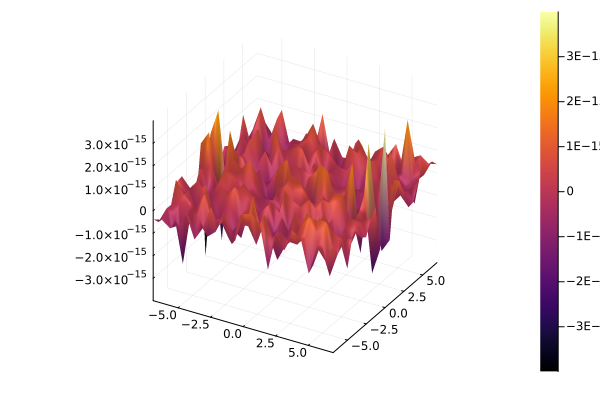

In [23]:
showMeThe(R4_omega)

In [24]:
A7 = c[1, 1]' * c[1, 1]
B7 = c[1, 1]' * c[1, 2]
C7 = c[1, 2]' * c[1, 1]

R7_tau = full_tau((A7,B7,C7), tautau, ham_eb, beta)

101×101 Matrix{Float64}:
 0.292593  -1.37948e-18  -8.9077e-18  …  7.36755e-17  8.45858e-17
 0.263909   0.227081      0.00134698     0.0275444    0.0368281
 0.24343    0.20578       0.18047        0.0472173    0.0629601
 0.228489   0.190435      0.164286       0.0615307    0.0818333
 0.217362   0.179132      0.152517       0.0721421    0.0957148
 0.208912   0.17063       0.143762    …  0.0801577    0.106114
 0.202374   0.164108      0.137109       0.0863253    0.11405
 0.197226   0.159014      0.131957       0.091157     0.120214
 0.193105   0.154967      0.127894       0.0950084    0.125087
 0.189754   0.151698      0.124638       0.0981298    0.129004
 0.186989   0.14902       0.121988    …  0.1007       0.132205
 0.184675   0.146793      0.1198         0.102847     0.134859
 0.182713   0.144917      0.117968       0.104666     0.137092
 ⋮                                    ⋱               ⋮
 0.184675   0.144917      0.116416       0.1007       0.134859
 0.186989   0.146793      0.117

In [25]:
@time R7_omega = G_ABC_gl_transform_simplex(A7, B7, C7, H, beta, space, 11, 11)


 55.053478 seconds (15.23 M allocations: 1.742 GiB, 0.64% gc time)


23×23 Matrix{ComplexF64}:
  -4.54751e-5+3.13261e-14im  …   -0.00142577-0.0510453im
  -5.31356e-5-0.000327385im     -0.000947531-0.0288751im
  -6.28272e-5-0.000766252im     -0.000700227-0.0170145im
  -7.52841e-5-0.00135914im      -0.000567495-0.0105992im
  -9.15621e-5-0.00216793im      -0.000485032-0.00592464im
 -0.000113178-0.00328435im   …  -0.000435227-0.00191251im
 -0.000142259-0.00484783im      -0.000410338+0.00191251im
 -0.000181571-0.00708175im      -0.000405319+0.00592464im
 -0.000234113-0.0103995im       -0.000415798+0.0105992im
 -0.000301834-0.0158725im       -0.000436206+0.0170145im
 -0.000383083-0.0273392im    …  -0.000457971+0.0288751im
     0.139496-0.0510453im           0.139496+0.0510453im
 -0.000457971-0.0288751im       -0.000383083+0.0273392im
 -0.000436206-0.0170145im       -0.000301834+0.0158725im
 -0.000415798-0.0105992im       -0.000234113+0.0103995im
 -0.000405319-0.00592464im   …  -0.000181571+0.00708175im
 -0.000410338-0.00191251im      -0.000142259+0.00484783im

0.10184733322049094


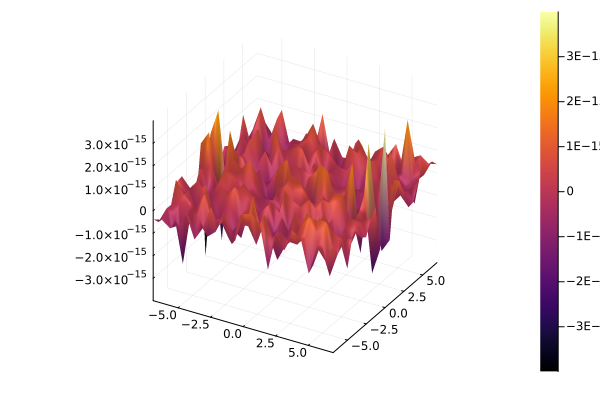

In [26]:
showMeThe(R7_omega)

In [30]:
function delta(term)
    if (real(term)+imag(term)) > -0.0000001 && 
       (real(term)+imag(term)) <  0.0000001
        return 1
    else
        return 0
    end
end

function integralterm(β, ϵ, ϵ_n, m, s, ω1, ω2, i, j)
    #term1
    term = delta(ϵ[s]-ϵ[m]-im*ω1[i])*delta(ϵ[m]-ϵ_n-im*ω2[j])*β*β/2
    if(isnan(term))
        println("term1")
    end
    #term2
    #-+
    td = delta(ϵ[s]-ϵ[m]-im*ω1[i])*(1-delta(ϵ[m]-ϵ_n-im*ω2[j]))
    td = td * (-ℯ^(-β*(ϵ[m]-ϵ_n-im*ω2[j]))/(ϵ[m]-ϵ_n-im*ω2[j])*β-(ℯ^(-β*(ϵ[m]-ϵ_n-im*ω2[j]))-1)/((ϵ[m]-ϵ_n-im*ω2[j])^2))
    term = term+td
     if(isnan(term))
        println("term2")
    end   
    #term3
    #+-
    td = (1-delta(ϵ[s]-ϵ[m]-im*ω1[i]))/(ϵ[s]-ϵ[m]-im*ω1[i])
    td = td * (+β*delta(ϵ[m]-ϵ_n-im*ω2[j])+(1-delta(ϵ[m]-ϵ_n-im*ω2[j]))*-(ℯ^(-β*(ϵ[m]-ϵ_n-im*ω2[j]))-1)/(ϵ[m]-ϵ_n-im*ω2[j]))
    term = term+td
    if(isnan(term))
        println("term3")
    end
    #mixed frequency term1
    td = (1-delta(ϵ[s]-ϵ[m]-im*ω1[i]))/(ϵ[s]-ϵ[m]-im*ω1[i])
    td = td * delta(ϵ[s]-ϵ_n-im*ω1[i]-im*ω2[j])*β
    term = term+td
    if(isnan(term))
        println("termm1")
    end
    #mixed frequency term2
    td = (1-delta(ϵ[s]-ϵ[m]-im*ω1[i]))/(ϵ[s]-ϵ[m]-im*ω1[i])
    if(isnan(td))
        println("td1")
    end
    td = td * (1-delta(ϵ[s]-ϵ_n-im*ω1[i]-im*ω2[j]))
    if(isnan(td))
        println("td2")
    end
    td = td * -(ℯ^(β*(ϵ[s]-ϵ_n-im*ω1[i]-im*ω2[j]))-1)/(ϵ[s]-ϵ_n-im*ω1[i]-im*ω2[j])
    if(isnan(td))
        println("td3")
    end
    term = term+td
    if(isnan(term))
        println("termm2")
    end
    return term
end

function isnearzero(val)
    if real(val)+imag(val) > -0.00000001 &&
       real(val)+imag(val) < 0.00000001
        return true
    end
    return false
end

function integralterm1(β, ϵ, ϵ_n, m, s, ω1, ω2, i, j)
    
    term = 0
    #swap omegas \nu = 1 \mu = 2
    enval1 = ϵ[s]-ϵ[m]-im*ω2[j]
    enval2 = ϵ[m]-ϵ_n-im*ω1[i]
    envalm = ϵ[s]-ϵ_n-im*ω1[i]-im*ω2[j]
    
    if isnearzero(enval1)
        if isnearzero(enval2)
        #term1
        term = term - (β^2)/2
        else
            #.+
        term = term + (β*ℯ^(-β*enval2)  )/(enval2  )
        term = term + (1*ℯ^(-β*enval2)-1)/(enval2^2) 
        end
    else
        #term2
        #.+-
        td = 1/enval1
        if isnearzero(enval2)
            td = td * - β
        else
            td = td * + (ℯ^(-β*enval2)-1)/(enval2)
        end
        term = term+td
        #term3
        #-
        td = 1/enval1 ###
        if isnearzero(envalm)
            td = td * + β
        else
            td = td * - (ℯ^(-β*envalm)-1)/envalm
        end
        term = term+td
    end 
    return term
end

function G_ABC_n_ord_Lehmann_Bosonic(Ψn::Array{Complex{T},2},ϵ::Array{T,1},ϵ_n::Real, A::Operator,B::Operator,
    C::Operator,n::Array{Complex{T},1}, ω1::Array{T,1},ω2::Array{T,1},β::Real) where T <: Real
    
    val_arr1 = zeros(length(ω1),length(ω2)) .+ 0im
    val_arr2 = zeros(length(ω1),length(ω2)) .+ 0im
    for i in 1:length(ω1), j in 1:length(ω2)
        val_arr1[i,j] = 0 + 0im
        val_arr2[i,j] = 0 + 0im
        for m in 1:length(ϵ), s in 1:length(ϵ)
            
            product = dot(n,A*Ψn[:,m])*dot(Ψn[:,m],B*Ψn[:,s])*dot(Ψn[:,s],C*n)
            ###
            term = integralterm1(β, ϵ, ϵ_n, m, s, ω1, ω2, i, j)

            product = term * product
            val_arr1[i,j] += product

            product = dot(n,B*Ψn[:,m])*dot(Ψn[:,m],A*Ψn[:,s])*dot(Ψn[:,s],C*n)
            ###
            term = integralterm1(β, ϵ, ϵ_n, m, s, ω2, ω1, j, i)

            product = term * product
            val_arr2[i,j] += product

        end
        val_arr1[i,j] *= exp(-ϵ_n*β)
        if wick_parity(A) * wick_parity(B) == 1 #two fermionic Operators
            println("fermionic??")
            val_arr2[i,j] *= -1.0*exp(-ϵ_n*β)
        else
            val_arr2[i,j] *= exp(-ϵ_n*β)
        end
    end
    return val_arr1+val_arr2
end

function G_ABC_Lehmann_Bosonic(A::Operator, B::Operator,C::Operator, τ1::Array{T,1},
    τ2::Array{T,1},H::Operator,β::Real, n_max1::Integer, n_max2::Integer) where T <: Real
    
    n1 = collect(-n_max1:1:n_max1)
    ω1 = (2n1)*π/β
    
    n2 = collect(-n_max2:1:n_max2)
    ω2 = (2n2)*π/β
    
    H_eigvec = eigvecs(Array(H)) .+ 0im
    H_eigene = eigvals(Array(H))
    H_eigene = H_eigene .- H_eigene[1] #shift spectrum
    Z = 0
    print(" length ")
    print(length(ω1))
    print(" x ")
    println(length(ω2))
    println(length(H_eigene))
    flush(stdout)
    result = zeros(length(τ1),length(τ2)) .+ 0im
    for i in 1:length(H_eigene)
        print("> eigen value: ")
        println(i)
        flush(stdout)
        if i == 1
            result=G_ABC_n_ord_Lehmann_Bosonic(H_eigvec,H_eigene,H_eigene[i],A,B,C,H_eigvec[:,i],ω1,ω2,β)
        else
            result=result .+ G_ABC_n_ord_Lehmann_Bosonic(H_eigvec,H_eigene,H_eigene[i],A,B,C,H_eigvec[:,i],ω1,ω2,β)
        end
        Z += exp(-β*H_eigene[i])
    end
    result = -1.0 .* result ./ Z
    return result
end

G_ABC_Lehmann_Bosonic (generic function with 1 method)

In [31]:
#n_max3 = 5
n_max3 = 1
n_max = n_max3
n3 = collect(-n_max:1:n_max)
n=n3
ω3 = (2n)*π/beta

τ1_arr = [0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]
τ2_arr = [0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]
#for i in 1:100
#    push!(τ1_arr,i/10)
#end

@time lehmann3 = G_ABC_Lehmann_Bosonic(A7,B7,C7,τ1_arr,τ2_arr,H,beta, n_max3, 0)[:,:]
transform3_Lehmann_imag = imag(lehmann3)
transform3_Lehmann_real = real(lehmann3)

 length 3 x 1
256
> eigen value: 1
> eigen value: 2
> eigen value: 3
> eigen value: 4
> eigen value: 5
> eigen value: 6
> eigen value: 7
> eigen value: 8
> eigen value: 9
> eigen value: 10
> eigen value: 11
> eigen value: 12
> eigen value: 13
> eigen value: 14
> eigen value: 15
> eigen value: 16
> eigen value: 17
> eigen value: 18
> eigen value: 19
> eigen value: 20
> eigen value: 21
> eigen value: 22
> eigen value: 23
> eigen value: 24
> eigen value: 25
> eigen value: 26
> eigen value: 27
> eigen value: 28
> eigen value: 29
> eigen value: 30
> eigen value: 31
> eigen value: 32
> eigen value: 33
> eigen value: 34
> eigen value: 35
> eigen value: 36
> eigen value: 37
> eigen value: 38
> eigen value: 39
> eigen value: 40
> eigen value: 41
> eigen value: 42
> eigen value: 43
> eigen value: 44
> eigen value: 45
> eigen value: 46
> eigen value: 47
> eigen value: 48
> eigen value: 49
> eigen value: 50
> eigen value: 51
> eigen value: 52
> eigen value: 53
> eigen value: 54
> eigen value: 55
>

3×1 Matrix{Float64}:
 -0.020978330452514477
  2.2427792877748405
 -0.020978330452514477

  0.340558 seconds (87.53 k allocations: 11.076 MiB)
[-0.020978330452514477; 2.2427792877748405; -0.020978330452514477;;]
[-0.020978330452512683; 2.242779287774809; -0.020978330452512683;;]


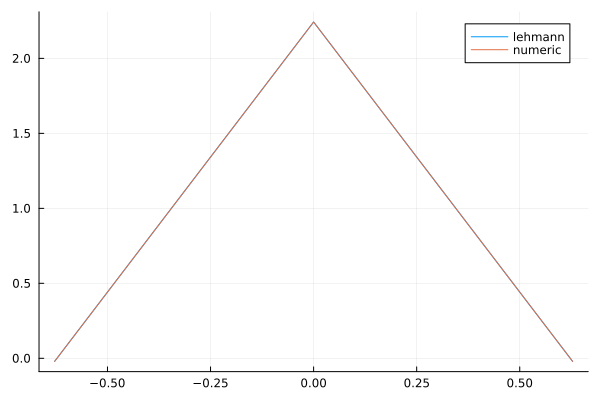

In [37]:
@time R1_omega1 = G_ABC_gl_transform_simplex(A7, B7, C7, H, beta, space, n_max3, 0)
#transform3_Lehmann_real
println(max.(transform3_Lehmann_real))
println(max.(real(R1_omega1)))
plot(ω3, (transform3_Lehmann_real), label = "lehmann")
plot!(ω3, real(R1_omega1), label = "numeric")

#heatmap(ω3, ω3, transform3_Lehmann_real, c = :thermal) 